In [2]:
!pip install netCDF4 einops
import netCDF4 as nc
import numpy as np
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import time  # For timing
import matplotlib.pyplot as plt

In [2]:
file_path = '/kaggle/input/tensor/tensor.npy'

# Load the .npy file into a NumPy array
reshaped_data = np.load(file_path)

reshaped_data = reshaped_data[:18000]
# Check the shape of the loaded data
print("Data shape:", reshaped_data.shape)

Data shape: (18000, 13, 32, 64)


In [ ]:
time_steps = reshaped_data.shape[0]  # Total time steps

# Define the time step offsets
t_offsets = [0, 6, 12]  # Offsets for t, t-6h, t-12h
t_plus_24h = 24         # Offset for t+24h

# Initialize empty lists to store the sequences and labels
X, y = [], []

# Create sequences and corresponding labels
for i in range(time_steps - t_plus_24h):
    # Input sequence: t, t-6h, t-12h
    sequence = np.concatenate([reshaped_data[i - offset] for offset in t_offsets], axis=0)
    
    if (i + t_plus_24h) < time_steps:
        # Ensure reshaped_data[i + t_plus_24h] has enough channels for indexing
        if reshaped_data[i + t_plus_24h].shape[0] >= 3:
            # Select specific channels for the label
            label = np.stack([
                reshaped_data[i + t_plus_24h][2, :, :],  # 2-meter temperature
                reshaped_data[i + t_plus_24h][0, :, :],  # Geopotential at 500 hPa
                reshaped_data[i + t_plus_24h][1, :, :]   # Temperature at 850 hPa
            ], axis=0)
            
            # Append the sequence and label to the lists
            X.append(sequence)
            y.append(label)

# Convert lists to numpy arrays

X = np.array(X)
y = np.array(y)

# Print shapes to verify
print("X shape:", X.shape)  # Expected: (num_sequences, 39, 32, 64)
print("y shape:", y.shape) 

In [ ]:
np.save('y.npy', y)
np.save('X.npy', X)
del y
del reshaped_data
X = np.load('X.npy')
y = np.load('y.npy')

In [ ]:
base_path_c = '/kaggle/input/constants/constants/constants.nc'

dataset_c = nc.Dataset(base_path_c, 'r')
oro = dataset_c.variables['orography'][:]
lat = dataset_c.variables['lat'][:]
lsm = dataset_c.variables['lsm'][:]

# Expand lat to match the shape of oro and lsm
lat_expanded = np.tile(lat[:, np.newaxis], (1, 64))

# Verify the shapes
print("Orography shape:", oro.shape)          # (32, 64)
print("Lat expanded shape:", lat_expanded.shape)  # (32, 64)
print("Land-sea mask shape:", lsm.shape)      # (32, 64)

# Expand the constants along the time dimension to match X's first dimension
oro_expanded = np.tile(oro[np.newaxis, :, :], (X.shape[0], 1, 1))
lat_expanded = np.tile(lat_expanded[np.newaxis, :, :], (X.shape[0], 1, 1))
lsm_expanded = np.tile(lsm[np.newaxis, :, :], (X.shape[0], 1, 1))

X = np.concatenate([X, oro_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lat_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lsm_expanded[:, np.newaxis, :, :]], axis=1)


del oro_expanded
del lat_expanded
del lsm_expanded

X = np.ma.filled(X, np.nan)


print("Data shape:", X.shape)

Orography shape: (32, 64)
Lat expanded shape: (32, 64)
Land-sea mask shape: (32, 64)


In [ ]:
np.save('X.npy', X)
del X
gc.collect()
X = np.load('X.npy')
y = np.load('y.npy')

In [ ]:

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)
X, y = [], []

del X
del y

gc.collect()

# Then split the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

In [3]:
X_test = np.load('/kaggle/input/data-train-x/X_test.npy')
y_test = np.load('/kaggle/input/data-train-y/y_test.npy')
X_train = np.load('/kaggle/input/data-train-x/X_train.npy')
y_train = np.load('/kaggle/input/data-train-y/y_train.npy')
X_val = np.load('/kaggle/input/data-train-x/X_val.npy')
y_val = np.load('/kaggle/input/data-train-y/y_val.npy')

In [17]:
print(X_train.shape)

(12583, 42, 32, 64)


In [4]:
class ClimateDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = self.X_data[idx]
        y = self.y_data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

In [5]:
batch_size = 32

y_train_t2m = y_train[:, 0:1, :, :] 
y_train_g500 = y_train[:, 1:1+1, :, :]
y_train_t850 = y_train[:, 2:2+1, :, :] 

y_val_t2m = y_val[:, 0:1, :, :] 
y_val_g500 = y_val[:, 1:1+1, :, :]
y_val_t850 = y_val[:, 2:2+1, :, :]

y_test_t2m = y_test[:, 0:1, :, :] 
y_test_g500 = y_test[:, 1:1+1, :, :] 
y_test_t850 = y_test[:, 2:2+1, :, :]

train_dataset = ClimateDataset(X_train, y_train_t2m)
val_dataset = ClimateDataset(X_val, y_val_t2m)
test_dataset = ClimateDataset(X_test, y_test_t2m)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [78]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes= 32 * 64):  # Adjust this to 3 channels of 32x64
        super(ResNet, self).__init__()
        self.layer1 = nn.Conv2d(42, 64, kernel_size=7, stride=2, padding=3)  # Adjust input channels to 9
        self.bn1 = nn.BatchNorm2d(64)
        self.layer2 = self._make_layer(64, 64, stride=1)
        self.layer3 = self._make_layer(64, 128, stride=2)
        self.fc = nn.Linear(128, num_classes)  # Match num_classes to 32*64

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 1, 32, 64)  # Reshape to 3 channels of 32x64
        return x

In [38]:
class PeriodicPadding(nn.Module):
    def __init__(self, padding):
        super(PeriodicPadding, self).__init__()
        self.padding = padding

    def forward(self, x):
        # Apply periodic padding on the left and right (longitude)
        x = F.pad(x, (self.padding, self.padding, 0, 0), mode='circular')
        # Apply zero padding on the top and bottom (latitude)
        x = F.pad(x, (0, 0, self.padding, self.padding), mode='constant', value=0)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = F.leaky_relu(self.bn1(out), negative_slope=0.3)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.leaky_relu(out, negative_slope=0.3)
        out = self.dropout(out)
        return out

class ResNet1(nn.Module):
    def __init__(self, num_classes=32*64, in_channels=42, num_blocks=28, hidden_dim=128, dropout_rate=0.1):
        super(ResNet1, self).__init__()
        self.periodic_padding = PeriodicPadding(padding=3)  # Padding size 3 for kernel size 7
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=7, stride=1, padding=0)  # Padding handled separately
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.residual_layers = self._make_layer(hidden_dim, hidden_dim, num_blocks, dropout_rate)
        
        self.fc = nn.Linear(hidden_dim, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, dropout_rate):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels, dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.periodic_padding(x)
        x = self.conv1(x)
        x = F.leaky_relu(self.bn1(x), negative_slope=0.3)
        x = self.dropout(x)
        
        x = self.residual_layers(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 1, 32, 64)  # Reshape to match target dimensions
        return x

# Example instantiation
model = ResNet1(num_classes=32*64, in_channels=42, num_blocks=28, hidden_dim=128, dropout_rate=0.1)

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=42, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

In [7]:
def latitude_weighting(latitudes):
    L = torch.cos(torch.deg2rad(latitudes))
    L /= L.sum() * 32  # Normalize so that the weights sum to 1
    return L

# Latitude-weighted RMSE calculation
def latitude_weighted_rmse(y_true, y_pred, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)

    # Reshape L to match the shape of y_true and y_pred
    L = L[None, None, :, None]  # Shape: (1, 1, H, 1)

    # Compute the difference and apply latitude weighting
    diff = y_pred - y_true  # Shape: (batch_size, channels, H, W)
    #print(diff.shape)
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))

    # Calculate RMSE
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)
    return rmse


def anomaly_correlation_coefficient(y_true, y_pred, latitudes):
    # Ensure that latitudes is a tensor and on the same device as the inputs
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)
    L = L[None, None, :, None]  # Reshape to match (batch_size, channels, H, W)

    # Calculate anomalies
    y_true_mean = torch.mean(y_true, dim=0, keepdim=True)
    y_true_anomaly = y_true - y_true_mean
    y_pred_anomaly = y_pred - y_true_mean

    # Numerator and denominator for ACC
    numerator = torch.sum(L * y_true_anomaly * y_pred_anomaly)
    denominator = torch.sqrt(torch.sum(L * y_true_anomaly ** 2) * torch.sum(L * y_pred_anomaly ** 2))

    acc = numerator / denominator

    return acc

In [8]:
# Set up the model, optimizer, and scheduler as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ResNet()
model = UNet().to(device)
#model = VisionTransformer().to(device)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1 if epoch >= 95 else 1.0)

In [13]:
class WarmUpLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, total_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        super(WarmUpLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            return [base_lr * (epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        else:
            return [base_lr * 0.5 * (1 + np.cos(np.pi * (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)))
                    for base_lr in self.base_lrs]

warmup_epochs = 5
total_epochs = 100
scheduler = WarmUpLR(optimizer, warmup_epochs, total_epochs)

def train_epoch(model, dataloader, criterion, optimizer, latitudes, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    # Wrap the dataloader with tqdm for progress tracking
    for inputs, labels in tqdm(dataloader, desc="Training Epoch", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = latitude_weighted_rmse2(labels, outputs, latitudes)
        loss.backward()
        optimizer.step()

        # Calculate ACC for this batch
        acc = anomaly_correlation_coefficient(labels, outputs, latitudes)
        running_loss += loss.item() * inputs.size(0)
        running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, latitudes, device):
    model.eval()
    running_loss = 0.0
    running_rmse = 0.0
    running_acc = 0.0
    with torch.no_grad():
        # Wrap the dataloader with tqdm for progress tracking
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate latitude-weighted RMSE
            rmse = latitude_weighted_rmse2(labels, outputs, latitudes)

            # Calculate Anomaly Correlation Coefficient (ACC)
            acc = anomaly_correlation_coefficient(labels, outputs, latitudes)

            running_loss += loss.item() * inputs.size(0)
            running_rmse += rmse.item() * inputs.size(0)
            running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_rmse = running_rmse / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_rmse, epoch_acc

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100, patience=5, device='cpu'):
    best_val_rmse = float('inf')
    patience_counter = 0

    latitudes = torch.arange(-87.1875, 92.8125, 180 / 32).to(device)  # Assuming 32 latitude points; adjust if necessary

    # Lists to store training and validation losses for each epoch
    train_losses = []
    val_losses = []

    # Start timing the entire training process
    start_time = time.time()

    for epoch in range(num_epochs):
        # Train for one epoch and get both loss and ACC
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, latitudes, device)
        train_losses.append(train_loss)

        # Evaluate on the validation set
        val_loss, val_rmse, val_acc = evaluate(model, val_loader, criterion, latitudes, device)
        val_losses.append(val_rmse)

        # Update learning rate
        scheduler.step()

        # Print the results
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train ACC: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val RMSE: {val_rmse:.4f} - Val ACC: {val_acc:.4f}")

        # Check for early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load the best model for testing
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

    # Evaluate on the test set
    test_loss, test_rmse, test_acc = evaluate(model, test_loader, criterion, latitudes, device)
    print(f"Test Loss: {test_loss:.4f} - Test RMSE: {test_rmse:.4f} - Test ACC: {test_acc:.4f}")

    # Calculate and print the total training time
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")

    # Plot the loss graph
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

/tmp/ipykernel_3225/1704004451.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/unett/pytorch/default/1/Unet_32_t2m.pth'))

Original input shape: torch.Size([32, 42, 32, 64])
Predicted value for sample 0 at latitude index 3 and longitude index 20: [221.90895]
Actual value for sample 0 at latitude index 3 and longitude index 20: [222.46484]


Predicted value for sample 1 at latitude index 3 and longitude index 20: [241.63184]
Actual value for sample 1 at latitude index 3 and longitude index 20: [241.20964]


Predicted value for sample 2 at latitude index 3 and longitude index 20: [230.28883]
Actual value for sample 2 at latitude index 3 and longitude index 20: [230.35193]


Predicted value for sample 3 at latitude index 3 and longitude index 20: [226.92928]
Actual value for sample 3 at latitude index 3 and longitude index 20: [227.51921]


Predicted value for sample 4 at latitude index 3 and longitude index 20: [232.38974]
Actual value for sample 4 at latitude index 3 and longitude index 20: [233.80994]


Predicted value for sample 5 at latitude index 3 and longitude index 20: [234.85301]
Actual value for sa

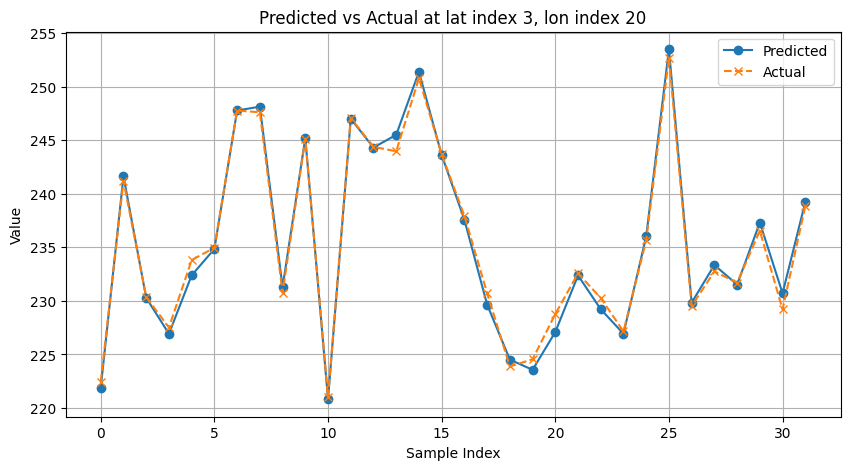

In [11]:
# Initialize the model and load weights
# model = ResNet()  # Assuming model is defined elsewhere
#model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=torch.device('cpu')))
model = UNet()  # Replace with your actual model class

# Load the model state_dict
model.load_state_dict(torch.load('/kaggle/input/unett/pytorch/default/1/Unet_32_t2m.pth'))
model.to(device)
model.eval()

# Use an iterator to get the specific batch from the DataLoader
data_iter = iter(test_loader)
batch_num = 1  # Change this to the desired batch index

# Retrieve the desired batch
for _ in range(batch_num):
    inputs, labels = next(data_iter)

inputs, labels = inputs.to(device), labels.to(device)

# Check the shape of the input
print(f"Original input shape: {inputs.shape}")  # Should be [batch_size, 9, height, width]

# Define latitude and longitude indices
latitude_index = 3  # Example index; adjust as needed
longitude_index = 20  # Example index; adjust as needed

# Make prediction for the entire batch
with torch.no_grad():
    predicted_output = model(inputs)

# Initialize lists to accumulate all predicted and actual values across the batch
all_predicted_values = []
all_actual_values = []

# Iterate over the batch to collect predicted vs actual values for each sample
for i in range(predicted_output.shape[0]):
    # Extract the predicted values for the specified latitude and longitude
    predicted_values = predicted_output[i, :, latitude_index, longitude_index].cpu().numpy()
    print(f"Predicted value for sample {i} at latitude index {latitude_index} and longitude index {longitude_index}: {predicted_values}")
    all_predicted_values.append(predicted_values)
    
    # Extract the actual values for the specified latitude and longitude
    actual_values = labels[i, :, latitude_index, longitude_index].cpu().numpy()
    all_actual_values.append(actual_values)
    print(f"Actual value for sample {i} at latitude index {latitude_index} and longitude index {longitude_index}: {actual_values}")
    print("\n")
    
# Convert lists to arrays for easier plotting
all_predicted_values = np.array(all_predicted_values).flatten()
all_actual_values = np.array(all_actual_values).flatten()

# Plot the accumulated predicted vs actual values
plt.figure(figsize=(10, 5))
plt.plot(all_predicted_values, label='Predicted', marker='o', linestyle='-')
plt.plot(all_actual_values, label='Actual', marker='x', linestyle='--')
plt.title(f'Predicted vs Actual at lat index {latitude_index}, lon index {longitude_index}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
file_path = '/kaggle/input/tensor/tensor.npy'

# Load the .npy file into a NumPy array
reshaped_data = np.load(file_path)

reshaped_data = reshaped_data[:18000]
# Check the shape of the loaded data
print("Data shape:", reshaped_data.shape)

Data shape: (18000, 13, 32, 64)


In [95]:
def prepare_data_for_iterative_forecasting(data, lead_time):
    inputs = []
    targets = []
    
    for i in range(len(data) - lead_time):
        # Convert numpy array to torch tensor
        inputs.append(torch.tensor(data[i], dtype=torch.float32))
        targets.append(torch.tensor(data[i + lead_time], dtype=torch.float32))
    
    return torch.stack(inputs), torch.stack(targets)

# Prepare data with lead_time=1 (6 hours ahead if each sample represents 6 hours)
inputs, targets = prepare_data_for_iterative_forecasting(reshaped_data, lead_time=6)
print(inputs.shape)
print(targets.shape)

torch.Size([17994, 13, 32, 64])
torch.Size([17994, 13, 32, 64])


In [96]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Assuming inputs and targets are already prepared
dataset = TensorDataset(inputs, targets)

# Split the dataset into training, validation, and testing (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each split
batch_size = 32  # Adjust based on your memory and performance
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [40]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes= 13 * 32 * 64):  # Adjust this to 3 channels of 32x64
        super(ResNet, self).__init__()
        self.layer1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3)  # Adjust input channels to 9
        self.bn1 = nn.BatchNorm2d(64)
        self.layer2 = self._make_layer(64, 64, stride=1)
        self.layer3 = self._make_layer(64, 128, stride=2)
        self.fc = nn.Linear(128, num_classes)  # Match num_classes to 32*64

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 13, 32, 64)  # Reshape to 3 channels of 32x64
        return x

In [97]:
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=13):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

In [98]:
def latitude_weighted_rmse1(y_pred, y_true, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)

    # Reshape L to match the shape of y_true and y_pred
    L = L[None, None, :, None]  # Shape: (1, 1, H, 1)

    # Compute the difference and apply latitude weighting
    diff = y_pred - y_true  # Shape: (batch_size, channels, H, W)
    #print(diff.shape)
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))

    # Calculate RMSE
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)
    loss = 1/y_true.size(1)*torch.sum(rmse)
    return loss




Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.35batch/s]


Epoch 1/1000 - Train Loss: 5542.6833 - Train ACC: 0.0000 - Val Loss: 252396539765.8985 - Val RMSE: 5542.0015 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.64batch/s]


Epoch 2/1000 - Train Loss: 5542.5749 - Train ACC: 0.0000 - Val Loss: 252395319251.9896 - Val RMSE: 5541.8266 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.87batch/s]


Epoch 3/1000 - Train Loss: 5542.2918 - Train ACC: 0.0000 - Val Loss: 252392370386.9463 - Val RMSE: 5541.4248 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.51batch/s]


Epoch 4/1000 - Train Loss: 5541.7422 - Train ACC: 0.0000 - Val Loss: 252386749248.4031 - Val RMSE: 5540.7213 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.68batch/s]


Epoch 5/1000 - Train Loss: 5540.8544 - Train ACC: 0.0000 - Val Loss: 252377206433.4346 - Val RMSE: 5539.6331 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.58batch/s]


Epoch 6/1000 - Train Loss: 5539.7123 - Train ACC: 0.0000 - Val Loss: 252365604479.2886 - Val RMSE: 5538.4636 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.73batch/s]


Epoch 7/1000 - Train Loss: 5538.5943 - Train ACC: 0.0000 - Val Loss: 252352955958.4439 - Val RMSE: 5537.4287 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.64batch/s]


Epoch 8/1000 - Train Loss: 5537.6155 - Train ACC: 0.0000 - Val Loss: 252339151421.6525 - Val RMSE: 5536.5009 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.33batch/s]


Epoch 9/1000 - Train Loss: 5536.6578 - Train ACC: 0.0000 - Val Loss: 252322854707.8829 - Val RMSE: 5535.5008 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.66batch/s]


Epoch 10/1000 - Train Loss: 5535.5771 - Train ACC: 0.0000 - Val Loss: 252303513993.8170 - Val RMSE: 5534.3393 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.71batch/s]


Epoch 11/1000 - Train Loss: 5534.3475 - Train ACC: 0.0000 - Val Loss: 252281179208.4654 - Val RMSE: 5533.0354 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.56batch/s]


Epoch 12/1000 - Train Loss: 5532.4415 - Train ACC: 0.0001 - Val Loss: 252244763118.7373 - Val RMSE: 5530.9515 - Val ACC: 0.0001


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 13/1000 - Train Loss: 5530.7846 - Train ACC: 0.0001 - Val Loss: 252213032397.7295 - Val RMSE: 5529.2924 - Val ACC: 0.0001


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.68batch/s]


Epoch 14/1000 - Train Loss: 5529.1311 - Train ACC: 0.0001 - Val Loss: 252179427186.8633 - Val RMSE: 5527.5494 - Val ACC: 0.0001


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.72batch/s]


Epoch 15/1000 - Train Loss: 5527.3947 - Train ACC: 0.0001 - Val Loss: 252147667728.5988 - Val RMSE: 5525.8967 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.41batch/s]


Epoch 16/1000 - Train Loss: 5525.5792 - Train ACC: 0.0002 - Val Loss: 252113293544.1927 - Val RMSE: 5524.0382 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.41batch/s]


Epoch 17/1000 - Train Loss: 5523.6934 - Train ACC: 0.0002 - Val Loss: 252074573745.0848 - Val RMSE: 5522.0495 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.59batch/s]


Epoch 18/1000 - Train Loss: 5521.7462 - Train ACC: 0.0002 - Val Loss: 252036313547.8325 - Val RMSE: 5520.0342 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.79batch/s]


Epoch 19/1000 - Train Loss: 5519.7407 - Train ACC: 0.0003 - Val Loss: 251988328611.9007 - Val RMSE: 5517.6786 - Val ACC: 0.0003


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.72batch/s]


Epoch 20/1000 - Train Loss: 5517.6433 - Train ACC: 0.0003 - Val Loss: 251959945034.6469 - Val RMSE: 5515.9714 - Val ACC: 0.0003


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.82batch/s]


Epoch 21/1000 - Train Loss: 5515.4990 - Train ACC: 0.0003 - Val Loss: 251918675541.5547 - Val RMSE: 5513.7695 - Val ACC: 0.0003


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.71batch/s]


Epoch 22/1000 - Train Loss: 5513.3063 - Train ACC: 0.0003 - Val Loss: 251877907311.4487 - Val RMSE: 5511.6481 - Val ACC: 0.0003


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.69batch/s]


Epoch 23/1000 - Train Loss: 5511.0669 - Train ACC: 0.0004 - Val Loss: 251834180036.2445 - Val RMSE: 5509.3510 - Val ACC: 0.0004


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.67batch/s]


Epoch 24/1000 - Train Loss: 5508.7848 - Train ACC: 0.0004 - Val Loss: 251790205240.6254 - Val RMSE: 5507.0080 - Val ACC: 0.0004


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.49batch/s]


Epoch 25/1000 - Train Loss: 5506.4642 - Train ACC: 0.0004 - Val Loss: 251746065834.0659 - Val RMSE: 5504.6367 - Val ACC: 0.0004


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.65batch/s]


Epoch 26/1000 - Train Loss: 5504.0912 - Train ACC: 0.0004 - Val Loss: 251701432795.0085 - Val RMSE: 5502.2884 - Val ACC: 0.0005


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.52batch/s]


Epoch 27/1000 - Train Loss: 5501.6517 - Train ACC: 0.0005 - Val Loss: 251644893438.1978 - Val RMSE: 5499.3370 - Val ACC: 0.0005


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.50batch/s]


Epoch 28/1000 - Train Loss: 5499.2286 - Train ACC: 0.0005 - Val Loss: 251599164510.4706 - Val RMSE: 5496.9269 - Val ACC: 0.0005


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.44batch/s]


Epoch 29/1000 - Train Loss: 5496.7920 - Train ACC: 0.0005 - Val Loss: 251556626280.2401 - Val RMSE: 5494.6180 - Val ACC: 0.0005


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 30/1000 - Train Loss: 5494.3465 - Train ACC: 0.0005 - Val Loss: 251508964392.5958 - Val RMSE: 5492.1202 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 31/1000 - Train Loss: 5491.8975 - Train ACC: 0.0006 - Val Loss: 251462592895.1938 - Val RMSE: 5489.6293 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.68batch/s]


Epoch 32/1000 - Train Loss: 5489.4512 - Train ACC: 0.0006 - Val Loss: 251421842936.9811 - Val RMSE: 5487.4088 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.72batch/s]


Epoch 33/1000 - Train Loss: 5487.0112 - Train ACC: 0.0006 - Val Loss: 251371052039.2086 - Val RMSE: 5484.5969 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.62batch/s]


Epoch 34/1000 - Train Loss: 5484.5737 - Train ACC: 0.0006 - Val Loss: 251332745913.3368 - Val RMSE: 5482.4471 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.54batch/s]


Epoch 35/1000 - Train Loss: 5482.1741 - Train ACC: 0.0006 - Val Loss: 251285193062.1534 - Val RMSE: 5480.2178 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.68batch/s]


Epoch 36/1000 - Train Loss: 5479.8047 - Train ACC: 0.0006 - Val Loss: 251241256103.3153 - Val RMSE: 5477.7333 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.67batch/s]


Epoch 37/1000 - Train Loss: 5477.4745 - Train ACC: 0.0006 - Val Loss: 251249437079.4754 - Val RMSE: 5478.5189 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.74batch/s]


Epoch 38/1000 - Train Loss: 5475.1880 - Train ACC: 0.0007 - Val Loss: 251153544659.7999 - Val RMSE: 5473.1303 - Val ACC: 0.0006


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.58batch/s]


Epoch 39/1000 - Train Loss: 5472.9487 - Train ACC: 0.0007 - Val Loss: 251102765799.6236 - Val RMSE: 5470.6974 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.75batch/s]


Epoch 40/1000 - Train Loss: 5470.7629 - Train ACC: 0.0007 - Val Loss: 251070986133.0093 - Val RMSE: 5469.1374 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.78batch/s]


Epoch 41/1000 - Train Loss: 5468.6313 - Train ACC: 0.0007 - Val Loss: 251026347120.6817 - Val RMSE: 5466.9920 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.47batch/s]


Epoch 42/1000 - Train Loss: 5466.5538 - Train ACC: 0.0007 - Val Loss: 250986702199.2264 - Val RMSE: 5465.1387 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.62batch/s]


Epoch 43/1000 - Train Loss: 5464.5240 - Train ACC: 0.0007 - Val Loss: 250935274049.4465 - Val RMSE: 5462.7852 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.70batch/s]


Epoch 44/1000 - Train Loss: 5462.5280 - Train ACC: 0.0008 - Val Loss: 250900387365.7503 - Val RMSE: 5461.3768 - Val ACC: 0.0007


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.62batch/s]


Epoch 45/1000 - Train Loss: 5460.5755 - Train ACC: 0.0008 - Val Loss: 250844027965.8422 - Val RMSE: 5459.0209 - Val ACC: 0.0008


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.72batch/s]


Epoch 46/1000 - Train Loss: 5458.6479 - Train ACC: 0.0008 - Val Loss: 250812033473.9681 - Val RMSE: 5457.5446 - Val ACC: 0.0008


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.42batch/s]


Epoch 47/1000 - Train Loss: 5456.7403 - Train ACC: 0.0008 - Val Loss: 250750127686.3787 - Val RMSE: 5455.0310 - Val ACC: 0.0009


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.66batch/s]


Epoch 48/1000 - Train Loss: 5454.8504 - Train ACC: 0.0009 - Val Loss: 250710071422.7195 - Val RMSE: 5453.3793 - Val ACC: 0.0009


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.33batch/s]


Epoch 49/1000 - Train Loss: 5452.9833 - Train ACC: 0.0009 - Val Loss: 250667363039.2768 - Val RMSE: 5451.5376 - Val ACC: 0.0009


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.58batch/s]


Epoch 50/1000 - Train Loss: 5451.1425 - Train ACC: 0.0009 - Val Loss: 250620808731.8859 - Val RMSE: 5449.7201 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.33batch/s]


Epoch 51/1000 - Train Loss: 5449.3330 - Train ACC: 0.0010 - Val Loss: 250582523299.9955 - Val RMSE: 5448.2472 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.64batch/s]


Epoch 52/1000 - Train Loss: 5447.5569 - Train ACC: 0.0010 - Val Loss: 250541376920.6136 - Val RMSE: 5446.4405 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 53/1000 - Train Loss: 5445.8180 - Train ACC: 0.0010 - Val Loss: 250491467092.3216 - Val RMSE: 5444.3182 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.41batch/s]


Epoch 54/1000 - Train Loss: 5444.1181 - Train ACC: 0.0011 - Val Loss: 250447296374.6573 - Val RMSE: 5442.5242 - Val ACC: 0.0011


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.46batch/s]


Epoch 55/1000 - Train Loss: 5442.4598 - Train ACC: 0.0011 - Val Loss: 250409453462.5269 - Val RMSE: 5440.7854 - Val ACC: 0.0011


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 56/1000 - Train Loss: 5440.8448 - Train ACC: 0.0011 - Val Loss: 250371373962.7655 - Val RMSE: 5439.3506 - Val ACC: 0.0011


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.77batch/s]


Epoch 57/1000 - Train Loss: 5439.2744 - Train ACC: 0.0012 - Val Loss: 250330732968.1689 - Val RMSE: 5437.6610 - Val ACC: 0.0012


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.52batch/s]


Epoch 58/1000 - Train Loss: 5437.7501 - Train ACC: 0.0012 - Val Loss: 250300008548.9203 - Val RMSE: 5436.4023 - Val ACC: 0.0012


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.55batch/s]


Epoch 59/1000 - Train Loss: 5436.2728 - Train ACC: 0.0012 - Val Loss: 250271949616.4683 - Val RMSE: 5435.2684 - Val ACC: 0.0012


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.60batch/s]


Epoch 60/1000 - Train Loss: 5434.8439 - Train ACC: 0.0012 - Val Loss: 250226954265.7992 - Val RMSE: 5433.3510 - Val ACC: 0.0012


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.64batch/s]


Epoch 61/1000 - Train Loss: 5433.4641 - Train ACC: 0.0013 - Val Loss: 250193425280.9011 - Val RMSE: 5432.0236 - Val ACC: 0.0013


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.52batch/s]


Epoch 62/1000 - Train Loss: 5432.1342 - Train ACC: 0.0013 - Val Loss: 250160321241.9652 - Val RMSE: 5430.6193 - Val ACC: 0.0013


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.64batch/s]


Epoch 63/1000 - Train Loss: 5430.8544 - Train ACC: 0.0013 - Val Loss: 250128647121.3338 - Val RMSE: 5429.2781 - Val ACC: 0.0013


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.65batch/s]


Epoch 64/1000 - Train Loss: 5429.6250 - Train ACC: 0.0013 - Val Loss: 250096423162.4038 - Val RMSE: 5427.9157 - Val ACC: 0.0013


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.54batch/s]


Epoch 65/1000 - Train Loss: 5428.4467 - Train ACC: 0.0014 - Val Loss: 250071736571.9214 - Val RMSE: 5426.8710 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.72batch/s]


Epoch 66/1000 - Train Loss: 5427.3193 - Train ACC: 0.0014 - Val Loss: 250046363577.4316 - Val RMSE: 5425.8073 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.76batch/s]


Epoch 67/1000 - Train Loss: 5426.2436 - Train ACC: 0.0014 - Val Loss: 250022508995.4857 - Val RMSE: 5424.8095 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.75batch/s]


Epoch 68/1000 - Train Loss: 5425.2190 - Train ACC: 0.0014 - Val Loss: 249992252373.1278 - Val RMSE: 5423.5330 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.73batch/s]


Epoch 69/1000 - Train Loss: 5424.2452 - Train ACC: 0.0014 - Val Loss: 249978786606.9507 - Val RMSE: 5422.9428 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.68batch/s]


Epoch 70/1000 - Train Loss: 5423.3211 - Train ACC: 0.0014 - Val Loss: 249959934335.1938 - Val RMSE: 5422.2292 - Val ACC: 0.0014


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.30batch/s]


Epoch 71/1000 - Train Loss: 5422.4471 - Train ACC: 0.0015 - Val Loss: 249938142801.7607 - Val RMSE: 5421.3922 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.66batch/s]


Epoch 72/1000 - Train Loss: 5421.6220 - Train ACC: 0.0015 - Val Loss: 249919597406.7551 - Val RMSE: 5420.6245 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.70batch/s]


Epoch 73/1000 - Train Loss: 5420.8444 - Train ACC: 0.0015 - Val Loss: 249897791541.1160 - Val RMSE: 5419.7508 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.80batch/s]


Epoch 74/1000 - Train Loss: 5420.1148 - Train ACC: 0.0015 - Val Loss: 249880162102.1593 - Val RMSE: 5419.0080 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.71batch/s]


Epoch 75/1000 - Train Loss: 5419.4324 - Train ACC: 0.0015 - Val Loss: 249864862487.4279 - Val RMSE: 5418.4127 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.52batch/s]


Epoch 76/1000 - Train Loss: 5418.7976 - Train ACC: 0.0015 - Val Loss: 249850148744.8685 - Val RMSE: 5417.7974 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.70batch/s]


Epoch 77/1000 - Train Loss: 5418.2079 - Train ACC: 0.0015 - Val Loss: 249835501133.2079 - Val RMSE: 5417.2046 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 78/1000 - Train Loss: 5417.6602 - Train ACC: 0.0015 - Val Loss: 249823064359.9318 - Val RMSE: 5416.6389 - Val ACC: 0.0015


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.48batch/s]


Epoch 79/1000 - Train Loss: 5417.1547 - Train ACC: 0.0016 - Val Loss: 249810508194.0985 - Val RMSE: 5416.1353 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.61batch/s]


Epoch 80/1000 - Train Loss: 5416.6864 - Train ACC: 0.0016 - Val Loss: 249800514136.2104 - Val RMSE: 5415.7017 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.63batch/s]


Epoch 81/1000 - Train Loss: 5416.2490 - Train ACC: 0.0016 - Val Loss: 249788330644.1556 - Val RMSE: 5415.1842 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.56batch/s]


Epoch 82/1000 - Train Loss: 5415.8640 - Train ACC: 0.0016 - Val Loss: 249782100347.3998 - Val RMSE: 5414.8951 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.82batch/s]


Epoch 83/1000 - Train Loss: 5415.5183 - Train ACC: 0.0016 - Val Loss: 249777222917.4064 - Val RMSE: 5414.6776 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.75batch/s]


Epoch 84/1000 - Train Loss: 5415.2061 - Train ACC: 0.0016 - Val Loss: 249769676249.1115 - Val RMSE: 5414.3696 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.79batch/s]


Epoch 85/1000 - Train Loss: 5414.9266 - Train ACC: 0.0016 - Val Loss: 249766676829.8066 - Val RMSE: 5414.1785 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.74batch/s]


Epoch 86/1000 - Train Loss: 5414.6784 - Train ACC: 0.0016 - Val Loss: 249759237698.5847 - Val RMSE: 5413.9305 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.73batch/s]


Epoch 87/1000 - Train Loss: 5414.4592 - Train ACC: 0.0016 - Val Loss: 249750913066.4928 - Val RMSE: 5413.5934 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.65batch/s]


Epoch 88/1000 - Train Loss: 5414.2690 - Train ACC: 0.0016 - Val Loss: 249749107572.7603 - Val RMSE: 5413.5124 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.82batch/s]


Epoch 89/1000 - Train Loss: 5414.1079 - Train ACC: 0.0016 - Val Loss: 249744943141.1812 - Val RMSE: 5413.3713 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.75batch/s]


Epoch 90/1000 - Train Loss: 5413.9725 - Train ACC: 0.0016 - Val Loss: 249740568340.0133 - Val RMSE: 5413.2078 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.81batch/s]


Epoch 91/1000 - Train Loss: 5413.8588 - Train ACC: 0.0016 - Val Loss: 249738662344.7973 - Val RMSE: 5413.1421 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.73batch/s]


Epoch 92/1000 - Train Loss: 5413.7636 - Train ACC: 0.0016 - Val Loss: 249739576255.1227 - Val RMSE: 5413.1246 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.70batch/s]


Epoch 93/1000 - Train Loss: 5413.6865 - Train ACC: 0.0016 - Val Loss: 249735325071.5080 - Val RMSE: 5412.9906 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.77batch/s]


Epoch 94/1000 - Train Loss: 5413.6279 - Train ACC: 0.0016 - Val Loss: 249734222286.8677 - Val RMSE: 5412.9413 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.69batch/s]


Epoch 95/1000 - Train Loss: 5413.5838 - Train ACC: 0.0016 - Val Loss: 249733230639.0456 - Val RMSE: 5412.8922 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.78batch/s]


Epoch 96/1000 - Train Loss: 5413.5508 - Train ACC: 0.0016 - Val Loss: 249732567187.2071 - Val RMSE: 5412.8666 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.79batch/s]


Epoch 97/1000 - Train Loss: 5413.5287 - Train ACC: 0.0016 - Val Loss: 249732282509.8955 - Val RMSE: 5412.8516 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.75batch/s]


Epoch 98/1000 - Train Loss: 5413.5177 - Train ACC: 0.0016 - Val Loss: 249732424648.2282 - Val RMSE: 5412.8577 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.58batch/s]


Epoch 99/1000 - Train Loss: 5413.5104 - Train ACC: 0.0016 - Val Loss: 249732344027.2931 - Val RMSE: 5412.8562 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.70batch/s]


Epoch 100/1000 - Train Loss: 5413.5066 - Train ACC: 0.0016 - Val Loss: 249732348883.6102 - Val RMSE: 5412.8549 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.78batch/s]


Epoch 101/1000 - Train Loss: 5413.5066 - Train ACC: 0.0016 - Val Loss: 249732313201.8199 - Val RMSE: 5412.8537 - Val ACC: 0.0016


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.62batch/s]
/tmp/ipykernel_36/1871812427.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

Epoch 102/1000 - Train Loss: 5413.5067 - Train ACC: 0.0016 - Val Loss: 249732351020.3898 - Val RMSE: 5412.8550 - Val ACC: 0.0016
Early stopping


Evaluating: 100%|██████████| 85/85 [00:02<00:00, 34.46batch/s]


Test Loss: 250091473784.9837 - Test RMSE: 5413.0267 - Test ACC: 0.0016
Total Training Time: 3512.15 seconds


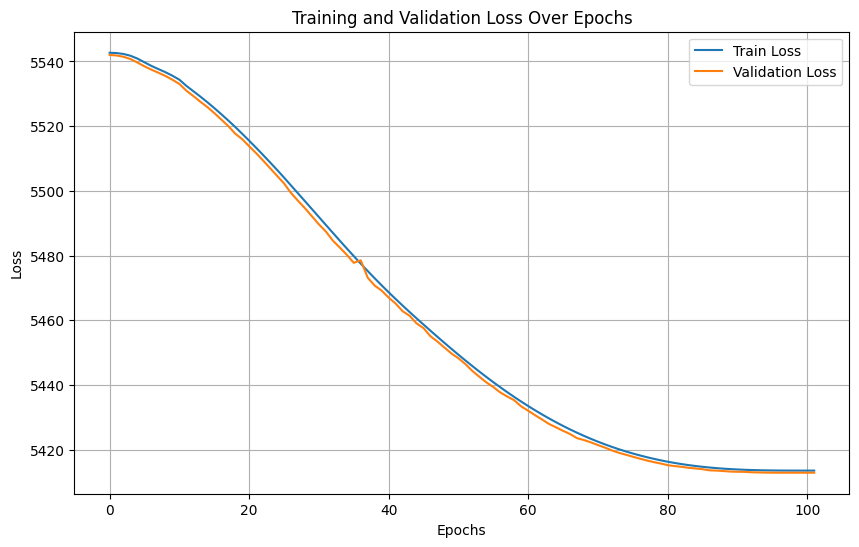

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = WarmUpLR(optimizer, warmup_epochs=5, total_epochs=100)

# Train the model
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

In [102]:
def iterative_forecasting(model, initial_input, num_iterations, device='cpu'):
    model.eval()
    forecasts = []
    current_input = initial_input.to(device)

    # Ensure the initial input has the correct number of channels
    if current_input.size(1) == 1:  # If only 1 channel, adjust if necessary
        current_input = current_input.repeat(1, 13, 1, 1)  # Example: repeat to match 13 channels
    
    with torch.no_grad():
        for _ in range(num_iterations):
            forecast = model(current_input)
            forecasts.append(forecast)
            current_input = forecast  # Feed the output back as input

    return torch.stack(forecasts, dim=1)


# Get an initial input from your test_loader
initial_input = next(iter(test_loader))[0].to(device)
num_iterations = 3  # Number of steps to forecast

# Perform iterative forecasting
iterative_forecasts = iterative_forecasting(model, initial_input, num_iterations, device=device)

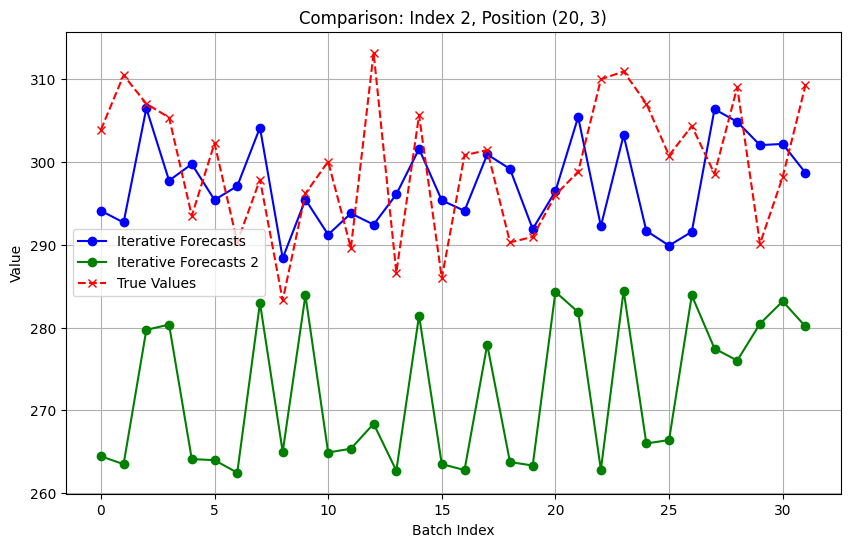

In [104]:
index = 2   # Example index from 0 to 12
pos1 = 20    # Example position in dimension 32
pos2 = 3    # Example position in dimension 64

# Extract data
data1 = iterative_forecasts[:, 0, index, pos1, pos2].cpu().numpy()  # Shape should be (32,)
data12 = iterative_forecasts[:, 1, index, pos1, pos2].cpu().numpy()  # Shape should be (32,)
data2 = true_values[:, index, pos1, pos2].cpu().numpy()             # Shape should be (32,)

# Plotting
plt.figure(figsize=(10, 6))

# Plot both datasets on the same plot
plt.plot(data1, marker='o', linestyle='-', color='b', label='Iterative Forecasts')
plt.plot(data12, marker='o', linestyle='-', color='g', label='Iterative Forecasts 2')
plt.plot(data2, marker='x', linestyle='--', color='r', label='True Values')

# Add titles and labels
plt.title(f'Comparison: Index {index}, Position ({pos1}, {pos2})')
plt.xlabel('Batch Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [3]:
time_steps = reshaped_data.shape[0]  # Total time steps

# Define the time step offsets
t_offsets = [0, 6, 12]  # Offsets for t, t-6h, t-12h
t_plus_24h = 24         # Offset for t+24h

# Initialize empty lists to store the sequences and labels
X, y = [], []

# Create sequences and corresponding labels
for i in range(time_steps - t_plus_24h):
    # Input sequence: t, t-6h, t-12h
    sequence = np.concatenate([reshaped_data[i - offset] for offset in t_offsets], axis=0)
    
    if (i + t_plus_24h) < time_steps:
        # Ensure reshaped_data[i + t_plus_24h] has enough channels for indexing
        if reshaped_data[i + t_plus_24h].shape[0] >= 3:
            # Initialize a list to collect labels for the next 24 hours
            labels = []
            for j in range(0, 24):
                label = reshaped_data[i + j][2, :, :]  # 2-meter temperature for time step i + j
                labels.append(label)  # Append each hourly label to the list
            
            # Stack the collected labels to form the final label tensor for this sequence
            labels = np.stack(labels, axis=0)  # Shape will be (24, 32, 64)
            
            # Append the sequence and label to the lists
            X.append(sequence)
            y.append(labels)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Print shapes to verify
print("X shape:", X.shape)  # Expected: (num_sequences, 39, 32, 64)
print("y shape:", y.shape)

X shape: (17976, 39, 32, 64)
y shape: (17976, 24, 32, 64)


In [ ]:
base_path_c = '/kaggle/input/constants/constants/constants.nc'

dataset_c = nc.Dataset(base_path_c, 'r')
oro = dataset_c.variables['orography'][:]
lat = dataset_c.variables['lat'][:]
lsm = dataset_c.variables['lsm'][:]

# Expand lat to match the shape of oro and lsm
lat_expanded = np.tile(lat[:, np.newaxis], (1, 64))

# Verify the shapes
print("Orography shape:", oro.shape)          # (32, 64)
print("Lat expanded shape:", lat_expanded.shape)  # (32, 64)
print("Land-sea mask shape:", lsm.shape)      # (32, 64)

# Expand the constants along the time dimension to match X's first dimension
oro_expanded = np.tile(oro[np.newaxis, :, :], (X.shape[0], 1, 1))
lat_expanded = np.tile(lat_expanded[np.newaxis, :, :], (X.shape[0], 1, 1))
lsm_expanded = np.tile(lsm[np.newaxis, :, :], (X.shape[0], 1, 1))

X = np.concatenate([X, oro_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lat_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lsm_expanded[:, np.newaxis, :, :]], axis=1)


del oro_expanded
del lat_expanded
del lsm_expanded

X = np.ma.filled(X, np.nan)


print("Data shape:", X.shape)

Orography shape: (32, 64)
Lat expanded shape: (32, 64)
Land-sea mask shape: (32, 64)


In [4]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)

del X
del y

gc.collect()

# Then split the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

In [7]:
batch_size = 32
train_dataset = ClimateDataset(X_train, y_train)
val_dataset = ClimateDataset(X_val, y_val)
test_dataset = ClimateDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=39, out_channels=24):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

In [9]:
def latitude_weighted_rmse2(y_pred, y_true, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)

    # Reshape L to match the shape of y_true and y_pred
    L = L[None, None, :, None]  # Shape: (1, 1, H, 1)

    # Compute the difference and apply latitude weighting
    diff = y_pred - y_true  # Shape: (batch_size, channels, H, W)
    #print(diff.shape)
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))

    # Calculate RMSE
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)
    loss = 1/y_true.size(1)*torch.sum(rmse)
    return loss

Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.09batch/s]


Epoch 1/1000 - Train Loss: 8.9003 - Train ACC: 0.0001 - Val Loss: 76349.6702 - Val RMSE: 8.8605 - Val ACC: 0.0001


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.96batch/s]


Epoch 2/1000 - Train Loss: 8.7584 - Train ACC: 0.0002 - Val Loss: 73417.3135 - Val RMSE: 8.6382 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.16batch/s]


Epoch 3/1000 - Train Loss: 8.4214 - Train ACC: 0.0006 - Val Loss: 67409.3176 - Val RMSE: 8.1696 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.67batch/s]


Epoch 4/1000 - Train Loss: 7.7630 - Train ACC: 0.0014 - Val Loss: 57165.0418 - Val RMSE: 7.3071 - Val ACC: 0.0021


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.98batch/s]


Epoch 5/1000 - Train Loss: 6.6481 - Train ACC: 0.0033 - Val Loss: 42896.1628 - Val RMSE: 5.9350 - Val ACC: 0.0050


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 6/1000 - Train Loss: 5.2313 - Train ACC: 0.0071 - Val Loss: 30727.4054 - Val RMSE: 4.5294 - Val ACC: 0.0092


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.08batch/s]


Epoch 7/1000 - Train Loss: 3.6853 - Train ACC: 0.0139 - Val Loss: 12918.1055 - Val RMSE: 2.1953 - Val ACC: 0.0227


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.12batch/s]


Epoch 8/1000 - Train Loss: 1.5459 - Train ACC: 0.0691 - Val Loss: 8017.9475 - Val RMSE: 1.1678 - Val ACC: 0.0963


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 9/1000 - Train Loss: 1.1066 - Train ACC: 0.1161 - Val Loss: 7647.1264 - Val RMSE: 1.0819 - Val ACC: 0.1251


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.18batch/s]


Epoch 10/1000 - Train Loss: 1.0782 - Train ACC: 0.1264 - Val Loss: 7624.7201 - Val RMSE: 1.0771 - Val ACC: 0.1324


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 11/1000 - Train Loss: 0.5725 - Train ACC: 0.3083 - Val Loss: 225.7768 - Val RMSE: 0.1936 - Val ACC: 0.6020


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.07batch/s]


Epoch 12/1000 - Train Loss: 0.1124 - Train ACC: 0.8172 - Val Loss: 11.7173 - Val RMSE: 0.0904 - Val ACC: 0.8800


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 13/1000 - Train Loss: 0.0836 - Train ACC: 0.8963 - Val Loss: 9.4144 - Val RMSE: 0.0810 - Val ACC: 0.9033


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 14/1000 - Train Loss: 0.0769 - Train ACC: 0.9125 - Val Loss: 9.1736 - Val RMSE: 0.0816 - Val ACC: 0.9032


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.10batch/s]


Epoch 15/1000 - Train Loss: 0.0707 - Train ACC: 0.9269 - Val Loss: 7.3378 - Val RMSE: 0.0721 - Val ACC: 0.9247


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.37batch/s]


Epoch 16/1000 - Train Loss: 0.0662 - Train ACC: 0.9359 - Val Loss: 7.3794 - Val RMSE: 0.0687 - Val ACC: 0.9322


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.66batch/s]


Epoch 17/1000 - Train Loss: 0.0625 - Train ACC: 0.9435 - Val Loss: 5.9384 - Val RMSE: 0.0625 - Val ACC: 0.9434


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.48batch/s]


Epoch 18/1000 - Train Loss: 0.0603 - Train ACC: 0.9474 - Val Loss: 5.6427 - Val RMSE: 0.0609 - Val ACC: 0.9466


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 19/1000 - Train Loss: 0.0582 - Train ACC: 0.9510 - Val Loss: 5.4873 - Val RMSE: 0.0609 - Val ACC: 0.9470


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.73batch/s]


Epoch 20/1000 - Train Loss: 0.0563 - Train ACC: 0.9542 - Val Loss: 4.6652 - Val RMSE: 0.0559 - Val ACC: 0.9551


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.70batch/s]


Epoch 21/1000 - Train Loss: 0.0549 - Train ACC: 0.9566 - Val Loss: 15.2490 - Val RMSE: 0.0961 - Val ACC: 0.8507


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.13batch/s]


Epoch 22/1000 - Train Loss: 0.0542 - Train ACC: 0.9575 - Val Loss: 4.3480 - Val RMSE: 0.0543 - Val ACC: 0.9575


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 23/1000 - Train Loss: 0.0515 - Train ACC: 0.9619 - Val Loss: 3.8180 - Val RMSE: 0.0516 - Val ACC: 0.9618


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.76batch/s]


Epoch 24/1000 - Train Loss: 0.0502 - Train ACC: 0.9639 - Val Loss: 4.3259 - Val RMSE: 0.0571 - Val ACC: 0.9543


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.49batch/s]


Epoch 25/1000 - Train Loss: 0.0489 - Train ACC: 0.9657 - Val Loss: 3.6769 - Val RMSE: 0.0506 - Val ACC: 0.9635


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 26/1000 - Train Loss: 0.0479 - Train ACC: 0.9672 - Val Loss: 3.3895 - Val RMSE: 0.0491 - Val ACC: 0.9655


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 27/1000 - Train Loss: 0.0468 - Train ACC: 0.9686 - Val Loss: 4.1248 - Val RMSE: 0.0532 - Val ACC: 0.9595


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 28/1000 - Train Loss: 0.0457 - Train ACC: 0.9701 - Val Loss: 3.0729 - Val RMSE: 0.0474 - Val ACC: 0.9679


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 29/1000 - Train Loss: 0.0450 - Train ACC: 0.9710 - Val Loss: 3.0216 - Val RMSE: 0.0462 - Val ACC: 0.9695


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.73batch/s]


Epoch 30/1000 - Train Loss: 0.0440 - Train ACC: 0.9722 - Val Loss: 2.9302 - Val RMSE: 0.0467 - Val ACC: 0.9688


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.99batch/s]


Epoch 31/1000 - Train Loss: 0.0431 - Train ACC: 0.9734 - Val Loss: 3.5460 - Val RMSE: 0.0485 - Val ACC: 0.9667


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 32/1000 - Train Loss: 0.0425 - Train ACC: 0.9742 - Val Loss: 2.6435 - Val RMSE: 0.0442 - Val ACC: 0.9721


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 33/1000 - Train Loss: 0.0415 - Train ACC: 0.9754 - Val Loss: 2.4341 - Val RMSE: 0.0419 - Val ACC: 0.9750


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.09batch/s]


Epoch 34/1000 - Train Loss: 0.0409 - Train ACC: 0.9760 - Val Loss: 2.6060 - Val RMSE: 0.0453 - Val ACC: 0.9709


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.20batch/s]


Epoch 35/1000 - Train Loss: 0.0403 - Train ACC: 0.9768 - Val Loss: 2.2298 - Val RMSE: 0.0404 - Val ACC: 0.9767


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 36/1000 - Train Loss: 0.0394 - Train ACC: 0.9778 - Val Loss: 2.0928 - Val RMSE: 0.0388 - Val ACC: 0.9785


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 37/1000 - Train Loss: 0.0389 - Train ACC: 0.9784 - Val Loss: 2.1871 - Val RMSE: 0.0398 - Val ACC: 0.9773


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.69batch/s]


Epoch 38/1000 - Train Loss: 0.0381 - Train ACC: 0.9793 - Val Loss: 2.7445 - Val RMSE: 0.0448 - Val ACC: 0.9723


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 39/1000 - Train Loss: 0.0376 - Train ACC: 0.9799 - Val Loss: 1.9491 - Val RMSE: 0.0382 - Val ACC: 0.9792


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.55batch/s]


Epoch 40/1000 - Train Loss: 0.0370 - Train ACC: 0.9804 - Val Loss: 1.8700 - Val RMSE: 0.0370 - Val ACC: 0.9804


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 41/1000 - Train Loss: 0.0366 - Train ACC: 0.9809 - Val Loss: 1.8542 - Val RMSE: 0.0365 - Val ACC: 0.9810


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 42/1000 - Train Loss: 0.0362 - Train ACC: 0.9813 - Val Loss: 2.0623 - Val RMSE: 0.0389 - Val ACC: 0.9784


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 43/1000 - Train Loss: 0.0356 - Train ACC: 0.9819 - Val Loss: 1.7156 - Val RMSE: 0.0359 - Val ACC: 0.9816


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 44/1000 - Train Loss: 0.0353 - Train ACC: 0.9822 - Val Loss: 1.9380 - Val RMSE: 0.0367 - Val ACC: 0.9808


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.31batch/s]


Epoch 45/1000 - Train Loss: 0.0349 - Train ACC: 0.9826 - Val Loss: 1.7014 - Val RMSE: 0.0354 - Val ACC: 0.9821


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 46/1000 - Train Loss: 0.0345 - Train ACC: 0.9830 - Val Loss: 1.6960 - Val RMSE: 0.0349 - Val ACC: 0.9827


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.07batch/s]


Epoch 47/1000 - Train Loss: 0.0341 - Train ACC: 0.9833 - Val Loss: 1.7450 - Val RMSE: 0.0353 - Val ACC: 0.9822


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.70batch/s]


Epoch 48/1000 - Train Loss: 0.0337 - Train ACC: 0.9838 - Val Loss: 1.6493 - Val RMSE: 0.0346 - Val ACC: 0.9829


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 49/1000 - Train Loss: 0.0335 - Train ACC: 0.9840 - Val Loss: 1.6549 - Val RMSE: 0.0352 - Val ACC: 0.9823


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 23.94batch/s]


Epoch 50/1000 - Train Loss: 0.0332 - Train ACC: 0.9842 - Val Loss: 1.5680 - Val RMSE: 0.0336 - Val ACC: 0.9839


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.82batch/s]


Epoch 51/1000 - Train Loss: 0.0328 - Train ACC: 0.9846 - Val Loss: 1.4941 - Val RMSE: 0.0329 - Val ACC: 0.9845


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.67batch/s]


Epoch 52/1000 - Train Loss: 0.0326 - Train ACC: 0.9848 - Val Loss: 1.5310 - Val RMSE: 0.0337 - Val ACC: 0.9838


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 53/1000 - Train Loss: 0.0323 - Train ACC: 0.9850 - Val Loss: 1.4863 - Val RMSE: 0.0328 - Val ACC: 0.9847


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 54/1000 - Train Loss: 0.0321 - Train ACC: 0.9853 - Val Loss: 1.5968 - Val RMSE: 0.0353 - Val ACC: 0.9823


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.24batch/s]


Epoch 55/1000 - Train Loss: 0.0319 - Train ACC: 0.9854 - Val Loss: 1.4608 - Val RMSE: 0.0324 - Val ACC: 0.9850


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 56/1000 - Train Loss: 0.0316 - Train ACC: 0.9857 - Val Loss: 1.4610 - Val RMSE: 0.0323 - Val ACC: 0.9852


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 57/1000 - Train Loss: 0.0314 - Train ACC: 0.9859 - Val Loss: 1.4425 - Val RMSE: 0.0323 - Val ACC: 0.9851


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.65batch/s]


Epoch 58/1000 - Train Loss: 0.0312 - Train ACC: 0.9861 - Val Loss: 1.4052 - Val RMSE: 0.0320 - Val ACC: 0.9854


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.89batch/s]


Epoch 59/1000 - Train Loss: 0.0310 - Train ACC: 0.9863 - Val Loss: 1.4156 - Val RMSE: 0.0316 - Val ACC: 0.9858


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 60/1000 - Train Loss: 0.0307 - Train ACC: 0.9865 - Val Loss: 1.3800 - Val RMSE: 0.0313 - Val ACC: 0.9860


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.48batch/s]


Epoch 61/1000 - Train Loss: 0.0305 - Train ACC: 0.9867 - Val Loss: 1.2905 - Val RMSE: 0.0306 - Val ACC: 0.9866


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.02batch/s]


Epoch 62/1000 - Train Loss: 0.0303 - Train ACC: 0.9868 - Val Loss: 1.4305 - Val RMSE: 0.0321 - Val ACC: 0.9853


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.78batch/s]


Epoch 63/1000 - Train Loss: 0.0301 - Train ACC: 0.9870 - Val Loss: 1.3641 - Val RMSE: 0.0312 - Val ACC: 0.9861


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 64/1000 - Train Loss: 0.0299 - Train ACC: 0.9872 - Val Loss: 1.2463 - Val RMSE: 0.0299 - Val ACC: 0.9872


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.87batch/s]


Epoch 65/1000 - Train Loss: 0.0297 - Train ACC: 0.9873 - Val Loss: 1.2494 - Val RMSE: 0.0299 - Val ACC: 0.9872


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 66/1000 - Train Loss: 0.0296 - Train ACC: 0.9875 - Val Loss: 1.2426 - Val RMSE: 0.0297 - Val ACC: 0.9874


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.85batch/s]


Epoch 67/1000 - Train Loss: 0.0294 - Train ACC: 0.9876 - Val Loss: 1.3045 - Val RMSE: 0.0311 - Val ACC: 0.9862


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 68/1000 - Train Loss: 0.0293 - Train ACC: 0.9877 - Val Loss: 1.2318 - Val RMSE: 0.0295 - Val ACC: 0.9876


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 69/1000 - Train Loss: 0.0291 - Train ACC: 0.9878 - Val Loss: 1.2187 - Val RMSE: 0.0294 - Val ACC: 0.9876


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 70/1000 - Train Loss: 0.0290 - Train ACC: 0.9880 - Val Loss: 1.2042 - Val RMSE: 0.0292 - Val ACC: 0.9878


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 71/1000 - Train Loss: 0.0289 - Train ACC: 0.9881 - Val Loss: 1.1931 - Val RMSE: 0.0291 - Val ACC: 0.9879


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.64batch/s]


Epoch 72/1000 - Train Loss: 0.0287 - Train ACC: 0.9881 - Val Loss: 1.2467 - Val RMSE: 0.0298 - Val ACC: 0.9873


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 73/1000 - Train Loss: 0.0286 - Train ACC: 0.9883 - Val Loss: 1.1766 - Val RMSE: 0.0289 - Val ACC: 0.9881


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.98batch/s]


Epoch 74/1000 - Train Loss: 0.0285 - Train ACC: 0.9883 - Val Loss: 1.1495 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 75/1000 - Train Loss: 0.0284 - Train ACC: 0.9884 - Val Loss: 1.1382 - Val RMSE: 0.0285 - Val ACC: 0.9884


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.83batch/s]


Epoch 76/1000 - Train Loss: 0.0283 - Train ACC: 0.9885 - Val Loss: 1.1451 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.72batch/s]


Epoch 77/1000 - Train Loss: 0.0282 - Train ACC: 0.9886 - Val Loss: 1.1432 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.74batch/s]


Epoch 78/1000 - Train Loss: 0.0281 - Train ACC: 0.9886 - Val Loss: 1.1422 - Val RMSE: 0.0285 - Val ACC: 0.9884


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.02batch/s]


Epoch 79/1000 - Train Loss: 0.0280 - Train ACC: 0.9887 - Val Loss: 1.1145 - Val RMSE: 0.0281 - Val ACC: 0.9887


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 80/1000 - Train Loss: 0.0280 - Train ACC: 0.9888 - Val Loss: 1.1159 - Val RMSE: 0.0282 - Val ACC: 0.9886


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.63batch/s]


Epoch 81/1000 - Train Loss: 0.0279 - Train ACC: 0.9888 - Val Loss: 1.1230 - Val RMSE: 0.0283 - Val ACC: 0.9885


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 82/1000 - Train Loss: 0.0278 - Train ACC: 0.9889 - Val Loss: 1.0955 - Val RMSE: 0.0281 - Val ACC: 0.9887


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.78batch/s]


Epoch 83/1000 - Train Loss: 0.0277 - Train ACC: 0.9890 - Val Loss: 1.0846 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.99batch/s]


Epoch 84/1000 - Train Loss: 0.0277 - Train ACC: 0.9890 - Val Loss: 1.0851 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 85/1000 - Train Loss: 0.0276 - Train ACC: 0.9891 - Val Loss: 1.0812 - Val RMSE: 0.0278 - Val ACC: 0.9890


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 86/1000 - Train Loss: 0.0276 - Train ACC: 0.9891 - Val Loss: 1.0821 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 87/1000 - Train Loss: 0.0275 - Train ACC: 0.9891 - Val Loss: 1.0824 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 88/1000 - Train Loss: 0.0275 - Train ACC: 0.9892 - Val Loss: 1.0678 - Val RMSE: 0.0276 - Val ACC: 0.9891


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 89/1000 - Train Loss: 0.0275 - Train ACC: 0.9891 - Val Loss: 1.0696 - Val RMSE: 0.0277 - Val ACC: 0.9890


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.90batch/s]


Epoch 90/1000 - Train Loss: 0.0274 - Train ACC: 0.9892 - Val Loss: 1.0663 - Val RMSE: 0.0276 - Val ACC: 0.9891


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.30batch/s]


Epoch 91/1000 - Train Loss: 0.0274 - Train ACC: 0.9893 - Val Loss: 1.0579 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.69batch/s]


Epoch 92/1000 - Train Loss: 0.0273 - Train ACC: 0.9892 - Val Loss: 1.0624 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 93/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0561 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 94/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0553 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 95/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0565 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.13batch/s]


Epoch 96/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0511 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 97/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0536 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 98/1000 - Train Loss: 0.0272 - Train ACC: 0.9894 - Val Loss: 1.0519 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 99/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0511 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 100/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0512 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.58batch/s]


Epoch 101/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0529 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 102/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0513 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 103/1000 - Train Loss: 0.0272 - Train ACC: 0.9894 - Val Loss: 1.0504 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 104/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0532 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.74batch/s]


Epoch 105/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0547 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 106/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0550 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.72batch/s]


Epoch 107/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0516 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.90batch/s]
/tmp/ipykernel_102/121138544.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

Epoch 108/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0529 - Val RMSE: 0.0274 - Val ACC: 0.9892
Early stopping


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.57batch/s]


Test Loss: 1.0437 - Test RMSE: 0.0274 - Test ACC: 0.9893
Total Training Time: 4064.13 seconds


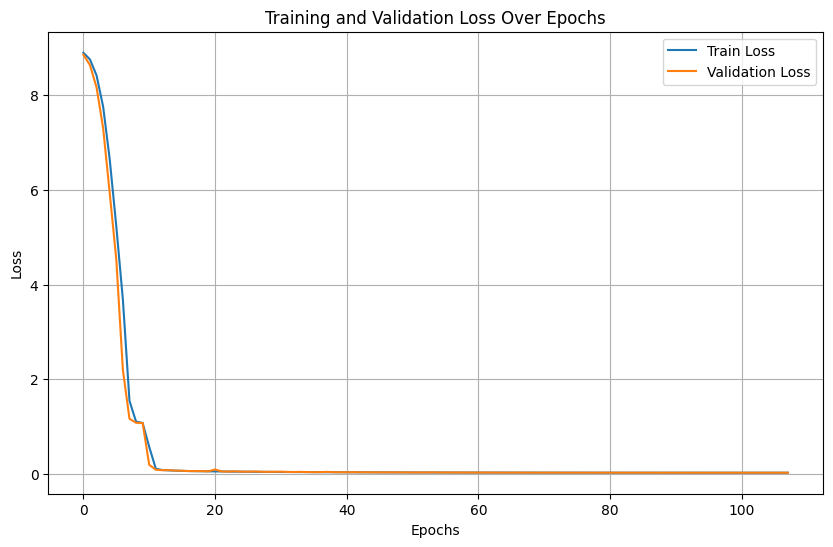

In [14]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

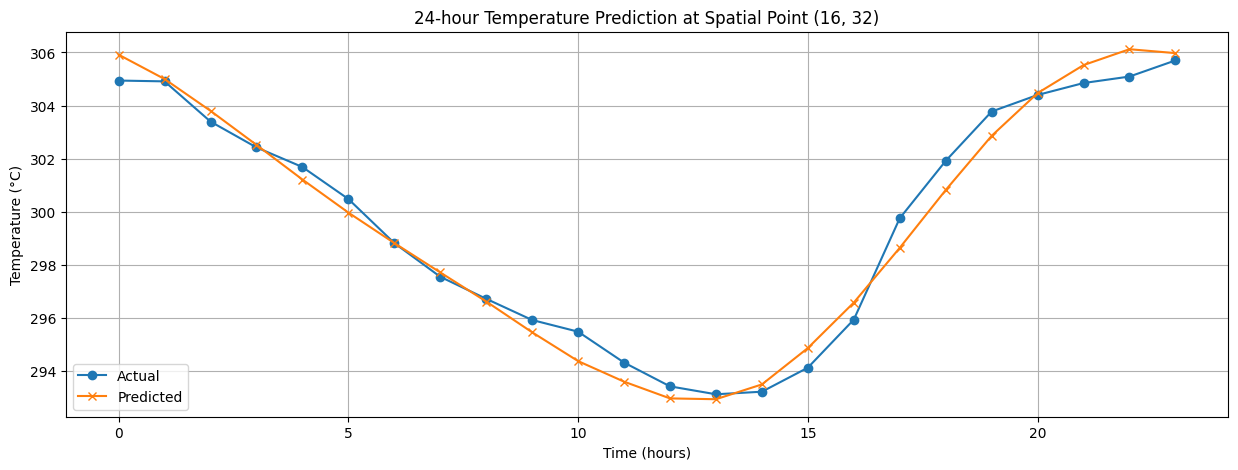

In [25]:
input_sequence = torch.tensor(X_test[sample_index:sample_index+1], dtype=torch.float32)

# Ensure the tensor is on the same device as the model (e.g., GPU or CPU)
input_sequence = input_sequence.to(next(model.parameters()).device)

# Generate prediction using your model
predicted_output = model(input_sequence)  # Output shape should be (1, 24, 32, 64)

# Remove the batch dimension (from shape (1, 24, 32, 64) to (24, 32, 64))
predicted_output = predicted_output.squeeze(0).cpu().detach().numpy()

# Extract the actual output for the same sample
actual_output = y_test[sample_index]

# Plot the results
plt.figure(figsize=(15, 5))

# Select a specific spatial point (e.g., at location (x, y) = (16, 32))
x, y = 20,3

# Plot actual values
plt.plot(range(24), actual_output[:, x, y], label='Actual', marker='o')

# Plot predicted values
plt.plot(range(24), predicted_output[:, x, y], label='Predicted', marker='x')

plt.title('24-hour Temperature Prediction at Spatial Point (16, 32)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')  # Adjust the unit accordingly
plt.legend()
plt.grid(True)
plt.show()

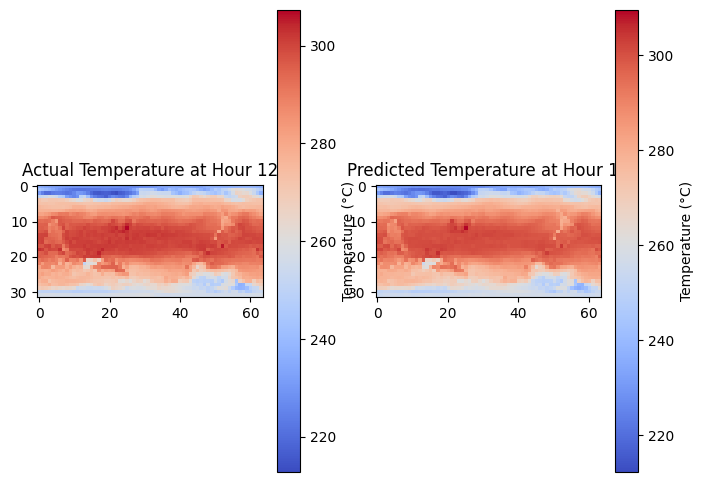

In [21]:
time_step = 12

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title(f'Actual Temperature at Hour {time_step}')
plt.imshow(actual_output[time_step, :, :], cmap='coolwarm', interpolation='none')
plt.colorbar(label='Temperature (°C)')

plt.subplot(1, 2, 2)
plt.title(f'Predicted Temperature at Hour {time_step}')
plt.imshow(predicted_output[time_step, :, :], cmap='coolwarm', interpolation='none')
plt.colorbar(label='Temperature (°C)')

plt.show()